In [1]:
# install reverse_geocoder
!pip install reverse_geocoder

# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import os
import matplotlib.dates as mdates
import datetime

# Data 200 - Graduate Project

Gavin Chan, Andrew Gorin, Xinchen Lu

**Research Question**: Our group intends to use Topic 2: Dataset A in order to explore the relationship between a variety of weather phenomena, likely heat and precipitation anomaly, and human behavior (e.g. crime, suicide, etc). This idea was partially inspired by Solomon Hsiang and Marshall Burke’s work on such subjects (Science, 2013; Nature Climate Change, 2018). In addition to the provided datasets, we’re considering including FBI crime data on arrests.

### Setup and Preprocessing

Run this on first time setup. It will create a dataset folder, download the necessary datasets, and unzip them. 

**Note**: this make take some time to run.

In [2]:
# Run this on first time setup. It will create a dataset folder,
# download the necesarry datasets, and unzip them.

# note, this may take some time to run.
download_unzip_datasets = False

if download_unzip_datasets:
    # source from:
    # https://stackoverflow.com/questions/19602931/basic-http-file-downloading-and-saving-to-disk-in-python
    import os
    import urllib.request 
    !pip install gdown
    import pathlib
    import zipfile
    import gdown
    import shutil
    
    dataset_path = "../data/"
    
    # create folder if doesn't exist
    # https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory
    pathlib.Path('../data').mkdir(parents=True, exist_ok=True) 
    print('Created datasets folder')
    
    # get NIBRS 2020 data
    # https://stackoverflow.com/questions/20338452/saving-files-downloaded-from-urlretrieve-to-another-folder-other
    url = "https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/masters/nibrs/nibrs-2020.zip"
    file_name = os.path.join(dataset_path, "nibrs-2019.zip")
    response = urllib.request.urlretrieve(url, file_name)
    print('Downloaded NIBRS 2020')
    
    # unzip file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print('Extracted NIBRS 2020')
    
    
    # get NIBRS 2019 data
    # https://stackoverflow.com/questions/20338452/saving-files-downloaded-from-urlretrieve-to-another-folder-other
    url = "https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/masters/nibrs/nibrs-2019.zip"
    file_name = os.path.join(dataset_path, "nibrs-2020.zip")
    response = urllib.request.urlretrieve(url, file_name)
    print('Downloaded NIBRS 2019')
    
       # unzip file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print('Extracted NIBRS 2019')
    
    
    # get NIBRS 2019 data
    # https://stackoverflow.com/questions/20338452/saving-files-downloaded-from-urlretrieve-to-another-folder-other
    url = "https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/masters/nibrs/nibrs-2018.zip"
    file_name = os.path.join(dataset_path, "nibrs-2018.zip")
    response = urllib.request.urlretrieve(url, file_name)
    print('Downloaded NIBRS 2018')
    
    # unzip file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print('Extracted NIBRS 2018')

    # get weather dataset from google drive
    # https://github.com/wkentaro/gdown
#     url = "https://drive.google.com/uc?id=15pjzsCiIE0uL69a4tZYgXoog8TKjIJNJ"
#     output = "./datasets/daily_global_weather_2020.csv"
#     gdown.download(url, output, quiet=False)
#     print('Downloaded Weather 2020 Data')

In [3]:
FBI_CRIME_2020_PATH = '../data/2020_NIBRS_NATIONAL_MASTER_FILE_ENC.txt'
FBI_CRIME_2019_PATH = '../data/2019_NIBRS_NATIONAL_MASTER_FILE_ENC_STATIC.txt'
FBI_CRIME_2018_PATH = '../data/2018_NIBRS_NATIONAL_MASTER_FILE_ENC.txt'
WEATHER_2020_PATH = '../data/daily_global_weather/daily_global_weather_2020.csv'

In [4]:
# read daily 2020 weather dataset
df_daily_global_weather = pd.read_csv(WEATHER_2020_PATH)

# df_daily_global_weather.describe()
df_daily_global_weather.head(5)

,Unnamed: 0,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation
0,0,AE000041196,2020-01-01,211.0,0.0,25.333,55.5170,34.0
1,1,AEM00041194,2020-01-01,217.0,0.0,25.255,55.3640,10.4
2,2,AFM00040938,2020-01-01,54.0,23.0,34.210,62.2280,977.2
3,3,AG000060611,2020-01-01,71.0,10.0,28.050,9.6331,561.0
4,4,AGE00147708,2020-01-01,99.0,0.0,36.720,4.0500,222.0


We can see that the granularity of the data is a measurement of temperature and precipitation for a given day at a particulation station. There is also station data, such as the station name, latitude, longitude, and elevation.

### Reverse Geocoding
We can find the location (such as a nearby town or city) by using the latitude and longitude data. We use the [reverse_geocoder](https://github.com/thampiman/reverse-geocoder) package.

In [5]:
# get the latitudes and longitudes from the dataframe, create each lat/long
# pair, and use reverse geocoder to get each location

latitudes = df_daily_global_weather['Latitude']
longitudes = df_daily_global_weather['Longitude']
pairs_locations = list(zip(latitudes, longitudes))
results = rg.search(pairs_locations)

Loading formatted geocoded file...


In [6]:
# create a dataframe with the results from the reverse geocoder search
df_locations = pd.DataFrame.from_dict(results)
print(df_locations.shape)

(1362814, 6)


In [7]:
# merge the geocoded locations with the weather dataset
df_daily_global_weather_location = (
    df_daily_global_weather.merge(right=df_locations,
    how="inner",
    left_index=True,
    right_index=True
    ))

Let's see what the dataset looks like if we are interested in California's weather.

In [8]:
# EDA: get the weather in California
df_daily_CA_weather = df_daily_global_weather_location[(df_daily_global_weather_location['cc'] == 'US') & (df_daily_global_weather_location['admin1'] == 'California')]
df_daily_CA_weather

,Unnamed: 0,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation,lat,lon,name,admin1,admin2,cc
3196,3196,USS0019L03S,2020-01-01,5.0,0.0,38.8500,-119.9400,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
3197,3197,USS0019L05S,2020-01-01,13.0,0.0,38.6100,-119.9200,2455.8,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
3199,3199,USS0019L07S,2020-01-01,23.0,0.0,38.3100,-119.6000,2690.5,38.25575,-119.23127,Bridgeport,California,Mono County,US
3200,3200,USS0019L08S,2020-01-01,30.0,0.0,38.3000,-119.5500,2194.0,38.25575,-119.23127,Bridgeport,California,Mono County,US
3201,3201,USS0019L13S,2020-01-01,32.0,0.0,38.0700,-119.2300,2878.8,38.25575,-119.23127,Bridgeport,California,Mono County,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362696,1362696,USW00023273,2020-12-31,97.0,3.0,34.8994,-120.4486,73.8,34.86526,-120.436,Orcutt,California,Santa Barbara County,US
1362724,1362724,USW00024216,2020-12-31,77.0,0.0,40.1519,-122.2536,107.6,40.17849,-122.23583,Red Bluff,California,Tehama County,US
1362733,1362733,USW00024257,2020-12-31,76.0,0.0,40.5175,-122.2986,151.5,40.44821,-122.29778,Anderson,California,Shasta County,US
1362756,1362756,USW00093193,2020-12-31,85.0,0.0,36.7800,-119.7194,101.5,36.79301,-119.70097,Tarpey Village,California,Fresno County,US


## Data Sampling and Collection

#### 1. How were the data collected?

Data from the Topic 2: Dataset A (Climate and the Environment - General Measurements and Statistics) is organized by the National Oceanic and Atmospheric Administration (NOAA) and includes daily land surface observations from stations across the world. From their [website](https://www.ncei.noaa.gov/cdo-web/datasets) and [documentation](https://www.ncei.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf), the data is collected as observations from the "World Meteorological Organization, Cooperative, and CoCoRaHS networks." Data, such as the temperature daily maximum/minimum which we are concerned with, are collected across more than 100,000 stations across the world.

Data from the NIBRS Crime Dataset is collected by station's submissions to the NIBRS System. Information is collected for each crime, such as "information on victims, known offenders, relationships between victims and offenders, arrestees, and property involved in crimes" (more information found [here](https://www.fbi.gov/how-we-can-help-you/need-an-fbi-service-or-more-information/ucr/nibrs).

#### 2. Was there any potential bias introduced in the sampling process?

For the weather dataset, there is a small chance of bias introduced due to the extensive [Data Integration and Quality Control](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily#tab-298) measures put into place by NOAA. Problems such as temperature consistency, data duplication, unverified stations, and more and hanlded by NOAA's methods before the data is uploaded into the dataset.

Bias could be introduced into the NIBRS Crime Dataset. According to the [FBI's website](https://www.fbi.gov/how-we-can-help-you/need-an-fbi-service-or-more-information/ucr/nibrs), transition to NIBRS from a previous system is still ongoing. NIBRS appears to collect more information that the previous system, therefore, the data could be biased with more information towards recent years. Therefore, data reporting could be bias towards (1) more recent years and (2) towards stations that have fully implemented NIBRS. However, data consistency is still prevalent as it is likely all crimes that are recorded are reported. Additionally, NIBRS includes [Dataset Quality Assurance measures](https://le.fbi.gov/file-repository/ucr-quality-assurance-review-methodology.pdf/view) to prevent invalid reporting of crime.

## Data Cleaning

#### 1. What type of data are you currently exploring?
#### 2. What is the granularity of the data?
#### 3. What does the distribution of the data look like? Are there any outliers? Are there any missing or invalid entries?

## EDA For Weather Dataset

First, we can load in all of the daily average weather data from 2010 to 2021. We store this data in `df_weather_years`. For the granularity of the data, each row holds the weather recorded by a data station on a particular day. That is, each row has the average temperature and and precipitation recorded by a weather station (with latitude, longitude) on a particular day of the year. We then append the reverse-geocoded location, which adds a city, state, county, and country to each row.

In [9]:
def load_US_weather():
    '''
    This function will read each file under ./daily_global_weather,
    extract the data corresponding to United States locations, 
    append to a dataframe, and return that dataframe
    '''
    files = os.listdir('../data/daily_global_weather/')
    df = None
    
    for name in files:
        path = '../data/daily_global_weather/{}'.format(name)
        
        curr_df = pd.read_csv(path)
        curr_df = curr_df.drop(columns='Unnamed: 0')
        
        # get the latitudes and longitudes from the dataframe, create each lat/long
        # pair, and use reverse geocoder to get each location
        latitudes = curr_df['Latitude']
        longitudes = curr_df['Longitude']
        pairs_locations = list(zip(latitudes, longitudes))
        results = rg.search(pairs_locations)
        
        # create a dataframe with the results from the reverse geocoder search
        df_locations = pd.DataFrame.from_dict(results)
        
        # merge the geocoded locations with the weather dataset
        curr_df = (
            curr_df.merge(right=df_locations,
            how="inner",
            left_index=True,
            right_index=True
            ))
        
        # only keep entries in the US
        curr_df = curr_df[curr_df['cc']=='US']
        
        if df is not None:
            df = pd.concat([df, curr_df])
        else:
            df = curr_df
            
        df = df.reset_index(drop=True)
    
    # https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
    # TVG is in tenths of degrees C, convert to Fahrenheit
    df['TAVG Fahrenheit'] = ((df['TAVG'] / 10) * (9./5)) + 32.
    
    # drop duplicate latitude and logitude
    df = df.drop(columns=['lat', 'lon'])
    
    # convert column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df

# df_weather_years hold all of the US weather from 2010 to 2021
df_weather_years = load_US_weather()
df_weather_years

,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation,name,admin1,admin2,cc,TAVG Fahrenheit
0,USS0003E03S,2010-01-01,-68.0,0.0,44.1100,-103.9800,2100.1,Lead,South Dakota,Lawrence County,US,19.76
1,USS0003E05S,2010-01-01,-49.0,0.0,44.2100,-103.7900,1868.4,Lead,South Dakota,Lawrence County,US,23.18
2,USS0004E07S,2010-01-01,-30.0,0.0,44.4900,-104.4100,1801.4,Sundance,Wyoming,Crook County,US,26.60
3,USS0005G04S,2010-01-01,-53.0,25.0,42.4400,-105.8600,2552.7,Glenrock,Wyoming,Converse County,US,22.46
4,USS0005G05S,2010-01-01,-38.0,25.0,42.2800,-105.5800,2407.9,Douglas,Wyoming,Converse County,US,25.16
...,...,...,...,...,...,...,...,...,...,...,...,...
4485037,USW00094847,2021-12-31,34.0,0.0,42.2314,-83.3308,192.3,Taylor,Michigan,Wayne County,US,38.12
4485038,USW00094849,2021-12-31,-3.0,0.0,45.0717,-83.5644,208.5,Alpena,Michigan,Alpena County,US,31.46
4485039,USW00094860,2021-12-31,13.0,5.0,42.8939,-85.5447,237.1,East Grand Rapids,Michigan,Kent County,US,34.34
4485040,USW00094908,2021-12-31,-23.0,0.0,42.3978,-90.7036,321.9,Dubuque,Iowa,Dubuque County,US,27.86


In [10]:
# rename name, admin1, and admin2 to city, state, and county
replace_loc_dic = {'name': 'city', 'admin1': 'state', 'admin2': 'county'}
df_weather_years = df_weather_years.rename(columns=replace_loc_dic)

We then can group by the date and the state (which will be useful later, as the resolution of the FBI crime data is by state) and average over the values. Average Longitude, latitude, and elevation may be useful during the Data Modeling portion of our project, so we include these values.

In [11]:
df_states_weather_years = (
    df_weather_years
    .groupby(['Date', 'state'])[['TAVG', 'PRCP', 'TAVG Fahrenheit', 'Latitude', 'Longitude', 'Elevation']]
    .mean()
    .reset_index()
)

df_states_weather_years

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation
0,2010-01-01,Alaska,-182.571429,1.020408,-0.862857,63.023061,-148.255918,492.018367
1,2010-01-01,Arizona,0.850000,3.750000,32.153000,34.536000,-110.615500,2457.385000
2,2010-01-01,California,8.730769,22.423077,33.571538,39.295000,-120.072692,2296.826923
3,2010-01-01,Colorado,-51.018692,17.448598,22.816636,39.095794,-106.624393,3071.671963
4,2010-01-01,Georgia,64.000000,43.000000,43.520000,32.350000,-85.000000,88.100000
...,...,...,...,...,...,...,...,...
175980,2021-12-31,Virginia,118.428571,9.571429,53.317143,37.825100,-77.522043,115.242857
175981,2021-12-31,Washington,-85.931034,0.724138,16.532414,47.372000,-120.901045,938.079310
175982,2021-12-31,West Virginia,90.250000,6.500000,48.245000,38.353325,-81.280225,474.525000
175983,2021-12-31,Wisconsin,-9.000000,3.250000,30.380000,43.618200,-89.153400,218.700000


As an example, we can plot the average temperature of a particular state (such as Texas). The plot is periodic, which corresponds to the seasonal changes in weather over a year.

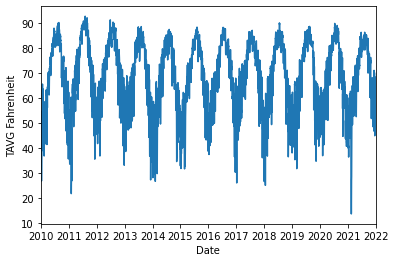

In [12]:
ax = sns.lineplot(data=df_states_weather_years\
                  [df_states_weather_years['state']=='Texas'],
                  x='Date',
                  y='TAVG Fahrenheit')

# https://matplotlib.org/2.0.2/examples/api/date_demo.html
datemin = datetime.date(df_states_weather_years['Date'].min().year, 1, 1)
datemax = datetime.date(df_states_weather_years['Date'].max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)

years = mdates.YearLocator()    # every year
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
plt.show()

We notice that some states (such as Iowa, Louisiana, Iowa, Michigan, and others) do not have data before 2013. However, this is acceptable, as we will be averaging over each day of the year in a later portion of the project. A limitation of this could be a misrepresented average, however, given more time for the project, we could collect weather data from more years (such as before 2010) to account for this missing data.

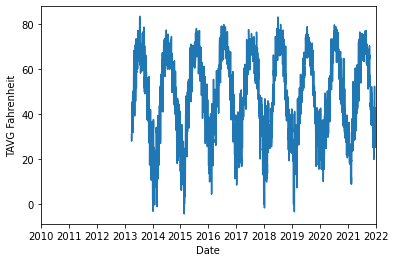

In [13]:
ax = sns.lineplot(data=df_states_weather_years\
                  [df_states_weather_years['state']=='Michigan'],
                  x='Date',
                  y='TAVG Fahrenheit')

# https://matplotlib.org/2.0.2/examples/api/date_demo.html
datemin = datetime.date(df_states_weather_years['Date'].min().year, 1, 1)
datemax = datetime.date(df_states_weather_years['Date'].max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)

years = mdates.YearLocator()    # every year
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
plt.show()

We can extract the day of the year from each date, which will be helpful in the Data Modeling portion of the project.

In [14]:
def extract_day_of_year(df):
    '''
    adds Day of Year as a column to dataframe
    '''
    df['Day of Year'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.day_of_year
    
    return df

df_states_weather_years = extract_day_of_year(df_states_weather_years)
df_states_weather_years

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year
0,2010-01-01,Alaska,-182.571429,1.020408,-0.862857,63.023061,-148.255918,492.018367,1
1,2010-01-01,Arizona,0.850000,3.750000,32.153000,34.536000,-110.615500,2457.385000,1
2,2010-01-01,California,8.730769,22.423077,33.571538,39.295000,-120.072692,2296.826923,1
3,2010-01-01,Colorado,-51.018692,17.448598,22.816636,39.095794,-106.624393,3071.671963,1
4,2010-01-01,Georgia,64.000000,43.000000,43.520000,32.350000,-85.000000,88.100000,1
...,...,...,...,...,...,...,...,...,...
175980,2021-12-31,Virginia,118.428571,9.571429,53.317143,37.825100,-77.522043,115.242857,365
175981,2021-12-31,Washington,-85.931034,0.724138,16.532414,47.372000,-120.901045,938.079310,365
175982,2021-12-31,West Virginia,90.250000,6.500000,48.245000,38.353325,-81.280225,474.525000,365
175983,2021-12-31,Wisconsin,-9.000000,3.250000,30.380000,43.618200,-89.153400,218.700000,365


The end goal is to calculate a metric 'away from the average' that is useful for data modeling. Therefore, we can calculate the Z-score (or standardized data with mean 0 and standard deviation of 1) of an input temperature with regards to its average on a particular day, which will return a value of "how many standard deviations away" is the input temperature. Let's look at a particular state, for example, Texas. 

We first calculate the average temperature and stand deviation for each day of the year.

Text(0.5, 1.0, 'Average Temperature vs. Day of the Year for Texas between 2010 and 2021')

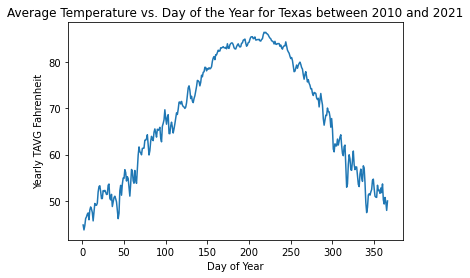

In [15]:
# get Texas weather and graph average over 2010-2021 years
df_weather_texas_raw = df_states_weather_years[df_states_weather_years['state']=='Texas']
df_weather_texas_average = (
    df_weather_texas_raw
    .groupby('Day of Year')[['TAVG Fahrenheit']]
    .mean()
    .rename(columns={'TAVG Fahrenheit': 'Yearly TAVG Fahrenheit'})
)

df_weather_texas_std = (
    df_weather_texas_raw
    .groupby('Day of Year')[['TAVG Fahrenheit']]
    .std()
    .rename(columns={'TAVG Fahrenheit': 'Yearly STD Fahrenheit'})
)

sns.lineplot(data=df_weather_texas_average, x='Day of Year', y='Yearly TAVG Fahrenheit')
plt.title('Average Temperature vs. Day of the Year for Texas between 2010 and 2021')

We can then merge the standard deviation and average into the dataframe, such that we can calculate Z-score.

In [17]:
# We then merge the average temperature and standard deviation into the df_weather_texas
# such that we can calculate a z-score for each temperature for plotting crime
df_weather_texas = (
    df_weather_texas_raw
    .merge(right=df_weather_texas_average, how='inner', on='Day of Year')
    .merge(right=df_weather_texas_std, how='inner', on='Day of Year')
)

# we can confirm that each average and standard deviation is added to the corresponding
# row by querying a particular day of the year
df_weather_texas[df_weather_texas['Day of Year']==9]

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Yearly TAVG Fahrenheit,Yearly STD Fahrenheit
96,2010-01-09,Texas,-3.000000,0.000000,31.460000,29.273300,-94.859200,1.500000,9,48.008505,8.64839
97,2011-01-09,Texas,82.500000,161.500000,46.850000,31.045000,-96.104600,108.200000,9,48.008505,8.64839
98,2012-01-09,Texas,132.000000,351.500000,55.760000,31.045000,-96.104600,108.200000,9,48.008505,8.64839
99,2013-01-09,Texas,135.000000,511.500000,56.300000,31.045000,-96.104600,108.200000,9,48.008505,8.64839
100,2014-01-09,Texas,92.083333,25.750000,48.575000,31.463979,-98.360917,365.225000,9,48.008505,8.64839
101,2015-01-09,Texas,22.250000,10.375000,36.005000,31.463979,-98.360917,365.225000,9,48.008505,8.64839
102,2016-01-09,Texas,80.833333,7.750000,46.550000,31.463979,-98.360917,365.225000,9,48.008505,8.64839
103,2017-01-09,Texas,102.541667,0.000000,50.457500,31.463979,-98.360917,365.225000,9,48.008505,8.64839
104,2018-01-09,Texas,102.434783,0.000000,50.438261,31.368752,-98.210800,337.917391,9,48.008505,8.64839
105,2019-01-09,Texas,111.625000,0.208333,52.092500,31.463979,-98.360917,365.225000,9,48.008505,8.64839


Finally, we calculate the Z-score and temperature ratio for each day-of-the-year's temperature from the calculated average for Texas.

In [133]:
df_weather_texas['Z-Score'] = \
    (df_weather_texas['TAVG Fahrenheit']\
    - df_weather_texas['Yearly TAVG Fahrenheit'])\
    / df_weather_texas['Yearly STD Fahrenheit']

df_weather_texas['Temp Ratio'] = \
    df_weather_texas['TAVG Fahrenheit']\
    / df_weather_texas['Yearly TAVG Fahrenheit']

df_weather_texas

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Yearly TAVG Fahrenheit,Yearly STD Fahrenheit,Z-Score,Temp Ratio
0,2010-01-01,Texas,60.500000,4.000000,42.890000,31.045000,-96.104600,108.200000,1,44.783723,8.822802,-0.214640,0.957714
1,2011-01-01,Texas,92.500000,0.000000,48.650000,31.045000,-96.104600,108.200000,1,44.783723,8.822802,0.438214,1.086332
2,2012-01-01,Texas,142.000000,5.000000,57.560000,31.045000,-96.104600,108.200000,1,44.783723,8.822802,1.448097,1.285288
3,2013-01-01,Texas,104.000000,522.000000,50.720000,31.045000,-96.104600,108.200000,1,44.783723,8.822802,0.672834,1.132554
4,2014-01-01,Texas,85.833333,2.708333,47.450000,31.463979,-98.360917,365.225000,1,44.783723,8.822802,0.302203,1.059537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376,2020-06-19,Texas,283.086957,112.782609,82.955652,31.368752,-98.210800,337.917391,171,83.056887,2.111766,-0.047939,0.998781
4377,2021-06-20,Texas,294.333333,8.166667,84.980000,31.463979,-98.360917,365.225000,171,83.056887,2.111766,0.910666,1.023154
4378,2012-12-31,Texas,104.000000,4.000000,50.720000,31.045000,-96.104600,108.200000,366,49.979130,4.933206,0.150180,1.014824
4379,2016-12-31,Texas,125.000000,63.958333,54.500000,31.463979,-98.360917,365.225000,366,49.979130,4.933206,0.916416,1.090455


## EDA For Crime Dataset

If we inspect the dataset for the FBI's NIBRS crime dataset, we find that its a large text file! Therefore, we have to read every line and inspect what each character position means. More data can be found [here](https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/masters/nibrs/nibrs-help.zip).

In [ ]:
with open(FBI_CRIME_2020_PATH) as file:
    count = 0
    for line in file:
        print(line)
        count+=1
        if count > 20:
            break

In [19]:
# read through each line of the FBI data and extract the line
# if it is an offence (code 02)
df_crime_data_2020 = pd.DataFrame()
input_string_arr = []
with open(FBI_CRIME_2020_PATH) as file:
    count = 0
    for line in file:
        if line[0:2] == '02':
            input_string_arr.append(line)
            count += 1
df_crime_data_2020['input_string'] = input_string_arr
            
print("Read in 2020")
df_crime_data_2019 = pd.DataFrame()
input_string_arr = []           
with open(FBI_CRIME_2019_PATH) as file:
    count = 0
    for line in file:
        if line[0:2] == '02':
            input_string_arr.append(line)
            count += 1
df_crime_data_2019['input_string'] = input_string_arr
            
            
print("Read in 2019")
df_crime_data_2018 = pd.DataFrame()
input_string_arr = []           
with open(FBI_CRIME_2018_PATH) as file:
    count = 0
    for line in file:
        if line[0:2] == '02':
            input_string_arr.append(line)
            count += 1

print("Read in 2018")

df_crime_data_2018['input_string'] = input_string_arr

display(df_crime_data_2020.head(5))

Read in 2020
Read in 2019
Read in 2018


,input_string
0,0201AL0010700 0E055CN33EM20200312250CN 24 P...
1,0201AL0010700 1FRBJSK-TT520200225220CN 20 F ...
2,0201AL0010700 286 AUA59PJ20200320220CN 20 N ...
3,0201AL0010700 90ALHXO1G1A2020041713ACN 20 ...
4,0201AL0010700 IDBE72OFU1920200218220CN 20 F ...


We then define a (big) function to translate the appropriate columns into the desired Pandas Dataframe.

In [20]:
def decode_raw_string(df):
    '''
    Split into appropriate columns
    Input: dataframe with raw string
    '''
    # segment level
    df['Segment Level'] = df['input_string'].str[0:2].astype(int)

    # state code 
    df['State Code'] = df['input_string'].str[2:4].astype(int)

    # originating agency identifier
    df['Originating Agency Identifier (ORI)'] = df['input_string'].str[4:13]

    # incident number
    df['Incident Number'] = df['input_string'].str[13:25]

    # incident date
    df['Incident Date'] = df['input_string'].str[25:33]

    # UCR offence code
    df['UCR Offense Code'] = df['input_string'].str[33:36]

    # offense attempted / completed
    df['Offense Attempted/Completed'] = df['input_string'].str[36]

    # offender suspected of using
    df['Suspected of Using 1'] = df['input_string'].str[37]
    df['Suspected of Using 2'] = df['input_string'].str[38]
    df['Suspected of Using 3'] = df['input_string'].str[39]

    # location type
    df['Location Type'] = df['input_string'].str[40:42]

    # number of premises entered
    df['Number of Premises Entered'] = df['input_string'].str[42:44]

    # method of entry
    df['Method of Entry - Force'] = df['input_string'].str[44]

    # type criminal activity
    df['Type Criminal Activity 1'] = df['input_string'].str[45]
    df['Type Criminal Activity 2'] = df['input_string'].str[46]
    df['Type Criminal Activity 3'] = df['input_string'].str[47]

    # type weapon/force involved, and automatic indicator
    df['Type Weapon/Force Involved 1'] = df['input_string'].str[48:50]
    df['Weapon 1 Automatic Indicator'] = df['input_string'].str[50]
    df['Type Weapon/Force Involved 2'] = df['input_string'].str[51:53]
    df['Weapon 2 Automatic Indicator'] = df['input_string'].str[53]
    df['Type Weapon/Force Involved 3'] = df['input_string'].str[54:56]
    df['Weapon 3 Automatic Indicator'] = df['input_string'].str[56]
    
    # bias motivation
    df['Bias Motivation'] = df['input_string'].str[57:59].astype(int)
    
    print('Finished getting substrings and converting to columns')
    
    replace_dict = {
        'UCR Offense Code' : {'200': 'Arson',
                              '13A': 'Aggravated Assault',
                              '13B': 'Simple Assault',
                              '13C': 'Intimidation',
                              '510': 'Bribery',
                              '220': 'Burglary/Breaking and Entering',
                              '250': 'Counterfeiting/Forgery',
                              '290': 'Destruction/Damage/Vandalism of Property',
                              '35A': 'Drug/Narcotic Violations',
                              '35B': 'Drug Equipment Violations',
                              '270': 'Embezzlement',
                              '210': 'Extortion/Blackmail',
                              '26A': 'False Pretenses/Swindle/Confidence Game',
                              '26B': 'Credit Card/Automatic Teller Machine Fraud',
                              '26C': 'Impersonation',
                              '26D': 'Wellfare Fraud',
                              '26E': 'Wire Fraud',
                              '39A': 'Betting/Wagering',
                              '39B': 'Operating/Promoting/Assisting Gambling',
                              '39C': 'Gambling Equipment Violations',
                              '39D': 'Sports Tampering',
                              '09A': 'Murder/Nonnegligent Manslaughter',
                              '09B': 'Negligent Manslaughter',
                              '09C': 'Justifiable Homocide',
                              '100': 'Kidnaping/Abduction',
                              '23A': 'Pocket-Picking',
                              '23B': 'Purse-snatching',
                              '23C': 'Shoplifting',
                              '23D': 'Theft From Building',
                              '23E': 'Theft from Coin-Operated Machine of Device',
                              '23F': 'Theft from Motor Vehicle',
                              '23G': 'Theft of Motor Vehicle Parts/Accessories',
                              '23H': 'All Other Larceny',
                              '240': 'Motor Vehicle Theft',
                              '370': 'Pornography/Obscene Material',
                              '40A': 'Prostitution',
                              '40B': 'Assisting or Promoting Prostitution',
                              '120': 'Robbery',
                              '11A': 'Forcible Rape',
                              '11B': 'Forcible Sodomy',
                              '11C': 'Sexual Assault With An Object',
                              '11D': 'Forcible Fondling (Incident Liberties/Child Molest)',
                              '36A': 'Incest',
                              '36B': 'Statuatory Rape',
                              '280': 'Stolen Property Offenses',
                              '520': 'Weapon Law Violations'
                              },
        'Offense Attempted/Completed': {' ': None,
                                        'A': 'Attempted',
                                        'C': 'Completed'
                                       },
        'Suspected of Using 1': {' ': None,
                                 'A': 'Alcohol',
                                 'C': 'Computer Equipment',
                                 'D': 'Drugs/Narcotics',
                                 'N': 'Not Applicable'
                                },
        'Suspected of Using 2': {' ': None,
                                 'A': 'Alcohol',
                                 'C': 'Computer Equipment',
                                 'D': 'Drugs/Narcotics',
                                 'N': 'Not Applicable'
                                },
        'Suspected of Using 3': {' ': None,
                                 'A': 'Alcohol',
                                 'C': 'Computer Equipment',
                                 'D': 'Drugs/Narcotics',
                                 'N': 'Not Applicable'
                                },
        'Location Type': {'  ': None,
                          '01': 'Air/Bus/Train Terminal',
                          '02': 'Bank/Savings and Loan',
                          '03': 'Bar/Nightclub',
                          '04': 'Church/Synagogue/Temple',
                          '05': 'Commercial/Office Building',
                          '06': 'Construction Site',
                          '07': 'Convenience Store',
                          '08': 'Department/Discount Store',
                          '09': "Drug Store/Dr.'s Office/Hospital",
                          '10': 'Field/Woods',
                          '11': 'Government/Public Building',
                          '12': 'Grocery/Supermarket',
                          '13': 'Highway/Road/Alley',
                          '14': 'Hotel/Motel/Etc.',
                          '15': 'Jail/Perison',
                          '16': 'Lake/Waterway',
                          '17': 'Liquor Store',
                          '18': 'Parking Lot/Garage',
                          '19': 'Rental Stor. Facil.',
                          '20': 'Residence/Home',
                          '21': 'Restaurant',
                          '22': 'School/College',
                          '23': 'Service/Gas Station',
                          '24': 'Sepecialty Store (TV, Fur, Etc.)',
                          '25': 'Other/Unknown'
                         },
        'Number of Premises Entered': {'  ': 0,
                                      },
        'Method of Entry - Force': {' ': None,
                                    'F': 1,
                                    'N': 0
                                   },
        'Type Criminal Activity 1':{' ': None,
                                    'B': 'Buying/Receiving',
                                    'C': 'Cultivating/Manufacturing/Publishing',
                                    'D': 'Distributing/Selling',
                                    'E': 'Exploting Children',
                                    'O': 'Operating/Promoting/Assisting',
                                    'P': 'Possessing/Concealing',
                                    'T': 'Transporting/Transmitting/Importing',
                                    'U': 'Using/Consuming'
                                   },
                    
        'Type Criminal Activity 2':{' ': None,
                                    'B': 'Buying/Receiving',
                                    'C': 'Cultivating/Manufacturing/Publishing',
                                    'D': 'Distributing/Selling',
                                    'E': 'Exploting Children',
                                    'O': 'Operating/Promoting/Assisting',
                                    'P': 'Possessing/Concealing',
                                    'T': 'Transporting/Transmitting/Importing',
                                    'U': 'Using/Consuming'
                                   },
        'Type Criminal Activity 3':{' ': None,
                                    'B': 'Buying/Receiving',
                                    'C': 'Cultivating/Manufacturing/Publishing',
                                    'D': 'Distributing/Selling',
                                    'E': 'Exploting Children',
                                    'O': 'Operating/Promoting/Assisting',
                                    'P': 'Possessing/Concealing',
                                    'T': 'Transporting/Transmitting/Importing',
                                    'U': 'Using/Consuming'
                                   },
        'Type Weapon/Force Involved 1': {'  ': None,
                                         '11': 'Firearm (type not stated)',
                                         '12': 'Handgun',
                                         '13': 'Rifle',
                                         '14': 'Shotgun',
                                         '15': 'Other Firearm',
                                         '20': 'Knife/Cutting Instrument (ice pick, screwdriver, ax, etc.)',
                                         '30': 'Blunt Object (club, hammer, etc.)',
                                         '35': 'Motor Vehicle',
                                         '40': 'Person Weapons (hands, feet, teeth, etc.)',
                                         '50': 'Poison (include gas)',
                                         '60': 'Explosives',
                                         '65': 'Fire/Incendiary Device',
                                         '70': 'Drugs/Narcotics/Sleeping Pills',
                                         '85': 'Asphyxiation (by drowning, strangulation, suffocation, gas, etc.)',
                                         '90': 'Other',
                                         '95': 'Unknown',
                                         '99': 'None'
                                         },
        'Weapon 1 Automatic Indicator': {'A': 1,
                                         ' ': 0
                                         },
        'Type Weapon/Force Involved 2': {'  ': None,
                                         '11': 'Firearm (type not stated)',
                                         '12': 'Handgun',
                                         '13': 'Rifle',
                                         '14': 'Shotgun',
                                         '15': 'Other Firearm',
                                         '20': 'Knife/Cutting Instrument (ice pick, screwdriver, ax, etc.)',
                                         '30': 'Blunt Object (club, hammer, etc.)',
                                         '35': 'Motor Vehicle',
                                         '40': 'Person Weapons (hands, feet, teeth, etc.)',
                                         '50': 'Poison (include gas)',
                                         '60': 'Explosives',
                                         '65': 'Fire/Incendiary Device',
                                         '70': 'Drugs/Narcotics/Sleeping Pills',
                                         '85': 'Asphyxiation (by drowning, strangulation, suffocation, gas, etc.)',
                                         '90': 'Other',
                                         '95': 'Unknown',
                                         '99': 'None'
                                         },
        'Weapon 2 Automatic Indicator': {'A': 1,
                                         ' ': 0
                                         },
        'Type Weapon/Force Involved 3': {'  ': None,
                                         '11': 'Firearm (type not stated)',
                                         '12': 'Handgun',
                                         '13': 'Rifle',
                                         '14': 'Shotgun',
                                         '15': 'Other Firearm',
                                         '20': 'Knife/Cutting Instrument (ice pick, screwdriver, ax, etc.)',
                                         '30': 'Blunt Object (club, hammer, etc.)',
                                         '35': 'Motor Vehicle',
                                         '40': 'Person Weapons (hands, feet, teeth, etc.)',
                                         '50': 'Poison (include gas)',
                                         '60': 'Explosives',
                                         '65': 'Fire/Incendiary Device',
                                         '70': 'Drugs/Narcotics/Sleeping Pills',
                                         '85': 'Asphyxiation (by drowning, strangulation, suffocation, gas, etc.)',
                                         '90': 'Other',
                                         '95': 'Unknown',
                                         '99': 'None'
                                         },
        'Weapon 3 Automatic Indicator': {'A': 1,
                                         ' ': 0
                                         },
        'Bias Motivation': {'  ': None,
                            11: 'White',
                            12: 'Black',
                            13: 'American Indian or Alaskan Native',
                            14: 'Asian/Pacific Islander',
                            15: 'Multi-Racial Group',
                            21: 'Jewish',
                            22: 'Catholic',
                            23: 'Protestant',
                            24: 'Islamic (Moslem)',
                            25: 'Other Religion',
                            26: 'Multi-Religious Group',
                            27: 'Atheism/Agnositicism',
                            31: 'Arab',
                            32: 'Hispanic',
                            33: 'Other Ethnicity/Natl. Origin',
                            41: 'Male Homosexiual (Gay)',
                            42: 'Female Homosexual (Lesbian)',
                            43: 'Homosexual (Gay and Lesbian)',
                            44: 'Heterosexual',
                            45: 'Bisexual',
                            88: 'None',
                            99: 'Unknown'
                            }
                    
                    }

    df.replace(replace_dict, inplace=True)

    df['Number of Premises Entered'] = df['Number of Premises Entered'].astype(int)
    
    return df

And finally, we can combine the three years of data that we have into one large dataframe.

In [21]:
df_crime_data_2020 = decode_raw_string(df_crime_data_2020)
print("Decoded 2020")

df_crime_data_2019 = decode_raw_string(df_crime_data_2019)
print("Decoded 2019")

df_crime_data_2018 = decode_raw_string(df_crime_data_2018)
print("Decoded 2018")

df_crime_data = pd.concat([df_crime_data_2020, df_crime_data_2019, df_crime_data_2018])
print("Combined dataframes!")

Finished getting substrings and converting to columns
Decoded 2020
Finished getting substrings and converting to columns
Decoded 2019
Finished getting substrings and converting to columns
Decoded 2018
Combined dataframes!


In [23]:
# convert the date to datetime format
df_crime_data['Incident Date'] = pd.to_datetime(df_crime_data['Incident Date'], yearfirst = True)

### Crime Dataset EDA - Offenses and Incidents
We can now do some basic EDA. For example, how many reporting agencies are there? How many unique incidents?

In [22]:
display(df_crime_data['Originating Agency Identifier (ORI)'].value_counts())
display(df_crime_data['Incident Number'].unique())

TXHPD0000    562688
TNMPD0000    283865
TXDPD0000    272485
MI8234900    236984
TN0190100    222436
              ...  
TX1522700         1
NY0015200         1
NY0550000         1
WV0050800         1
SC0082600         1
Name: Originating Agency Identifier (ORI), Length: 10040, dtype: int64

array([' 0E055CN33EM', ' 1FRBJSK-TT5', ' 286 AUA59PJ', ...,
       ' T0BAEQC728N', ' T0BAWMM728N', '4I1ZTOXTG0W5'], dtype=object)

What are the most common offenses? What is the granularity of the data?

In [24]:
# Some basic EDA
# What are the most common offenses?
print(df_crime_data['UCR Offense Code'].value_counts())

# What is granularity of the data? Is Each row a different incident? Let's check.
print(df_crime_data['Incident Number'].value_counts(ascending = False))

Simple Assault                                         2835704
Destruction/Damage/Vandalism of Property               2568366
All Other Larceny                                      2434626
Drug/Narcotic Violations                               2080385
Theft from Motor Vehicle                               1672188
Burglary/Breaking and Entering                         1433142
Shoplifting                                            1405246
Motor Vehicle Theft                                     981488
Drug Equipment Violations                               959664
Aggravated Assault                                      858524
Intimidation                                            842981
Theft From Building                                     603960
False Pretenses/Swindle/Confidence Game                 583317
Weapon Law Violations                                   436379
Credit Card/Automatic Teller Machine Fraud              393922
Theft of Motor Vehicle Parts/Accessories               

It looks like there are many incidents for which there are multiple entries, and many where there are only one. It looks like the granularity is arrests, and the incident data is actually an identifier for some crime that was comitted that multiple people may have been involved with. To further see this, let's look at the incident number with the most entries in detail.

In [25]:
# Okay, so the most common incident number is in the database 152 times and is 'H3-F3FLGRVSC'
# Let's take a look at all these incidents.

commonIncident = df_crime_data[df_crime_data['Incident Number'] == 'H3-F3FLGRVSC'] 
commonIncident.loc[:,['UCR Offense Code','Incident Date']]

,UCR Offense Code,Incident Date
693668,Counterfeiting/Forgery,2020-01-10
693669,Burglary/Breaking and Entering,2020-01-10
693670,Destruction/Damage/Vandalism of Property,2020-01-10
2089541,Motor Vehicle Theft,2020-01-10
2089542,All Other Larceny,2020-01-10
...,...,...
5133934,Burglary/Breaking and Entering,2020-01-29
5134026,Motor Vehicle Theft,2020-01-17
5136055,Destruction/Damage/Vandalism of Property,2020-01-06
5137551,Destruction/Damage/Vandalism of Property,2020-01-29


## Most popular crimes
We can then look at the most popular crimes as a function of time.

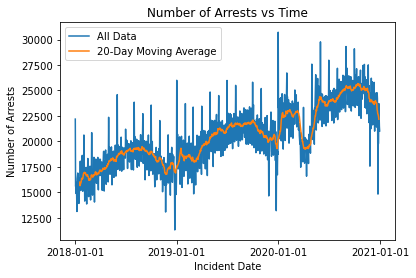

In [26]:
df_crime_data['Incident Date'] = pd.to_datetime(df_crime_data['Incident Date'], yearfirst = True)


#Let's start super simply by just viewing the number of arrests vs time
timevsArrests = df_crime_data.groupby(["Incident Date"]).count().iloc[:,0]
rollingAverage = timevsArrests.rolling(20).mean().shift(-3)
fig, ax = plt.subplots()
sns.lineplot(x = pd.to_datetime(timevsArrests.index),y=timevsArrests,ax=ax)
sns.lineplot(x = pd.to_datetime(rollingAverage.index), y = rollingAverage,ax=ax)
plt.xticks(["2018-01-01", "2019-01-01","2020-01-01","2021-01-01"])
plt.xlabel("Incident Date")
plt.ylabel("Number of Arrests")
plt.title("Number of Arrests vs Time")
plt.legend(["All Data", "20-Day Moving Average"])

In [27]:
pd.to_datetime("2018-01-01")

Timestamp('2018-01-01 00:00:00')

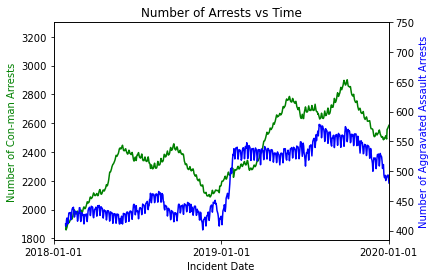

In [28]:
#There appears to be some seasonality in the data-- let's compare between a violent and nonviolent 
#crime to see if there is seasonality in both

aggAssaultOnly = df_crime_data[df_crime_data['UCR Offense Code'] == "Simple Assault"]
aggAssaultOnly = aggAssaultOnly.groupby("Incident Date").count().iloc[:,0]

consOnly = df_crime_data[df_crime_data["UCR Offense Code"] == "False Pretenses/Swindle/Confidence Game"]
consOnly = consOnly.groupby("Incident Date").count().iloc[:,0]
fig, ax = plt.subplots()
sns.lineplot(x = aggAssaultOnly.index,y=aggAssaultOnly.rolling(30).mean().shift(-3),ax=ax,color = "g")
plt.ylabel("Number of ""Con-man"" Arrests",color="g")

ax2 = plt.twinx()
sns.lineplot(x = consOnly.index, y = consOnly.rolling(30).mean().shift(-3),ax=ax2, color = "b")
plt.xticks(["2018-01-01", "2019-01-01","2020-01-01","2021-01-01"])
plt.xlabel("Incident Date")
plt.ylabel("Number of Aggravated Assault Arrests",color="b")
plt.title("Number of Arrests vs Time")
plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2020-01-01"));


## Combining the Data and Plotting
Now that we have both the crime data and weather data for 2018-2020, we can create some plots to see the relationship between temperature and different types of crime.

In [29]:
df_simple_assault_Texas_by_date = (
    df_crime_data[(df_crime_data['UCR Offense Code']=='Simple Assault')
                  & (df_crime_data['State Code']==42)]
    .groupby('Incident Date')
    .size()

)                                 
df_simple_assault_Texas_by_date

Incident Date
2018-01-01    200
2018-01-02    108
2018-01-03    108
2018-01-04    107
2018-01-05    135
             ... 
2020-12-27    659
2020-12-28    535
2020-12-29    513
2020-12-30    440
2020-12-31    502
Length: 1096, dtype: int64

In [30]:
df_weather_texas_by_date = (
    df_weather_years[df_weather_years['state']=='Texas']
    .groupby('Date')[['TAVG Fahrenheit']]
    .mean()
)

df_weather_texas_by_date.index = df_weather_texas_by_date.index.astype(str)

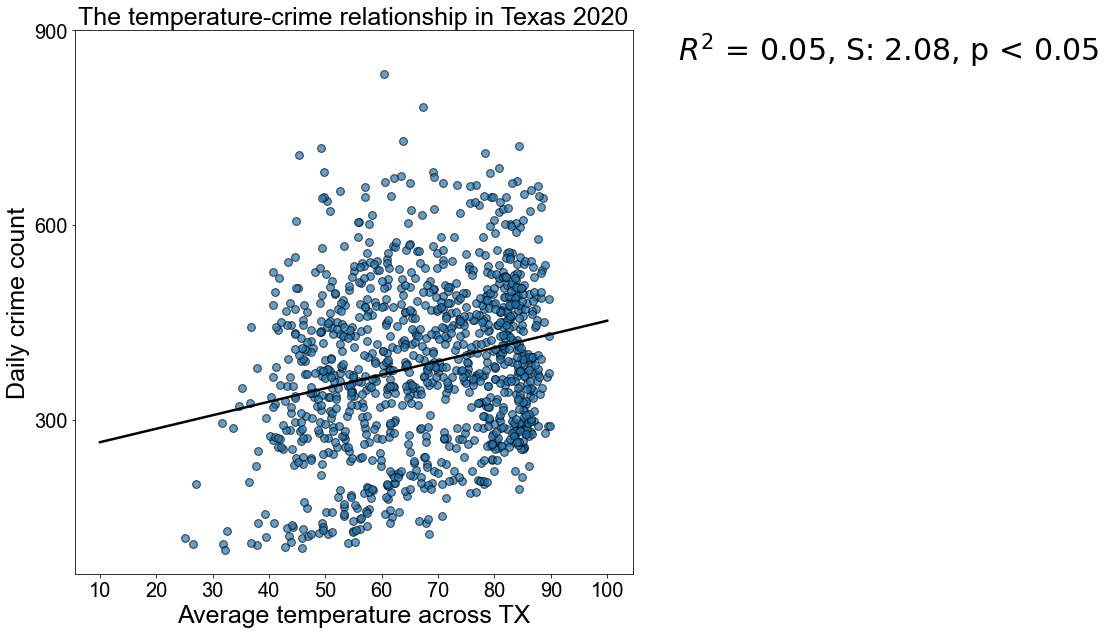

In [31]:
from sklearn.metrics import r2_score
from scipy.stats import linregress

df_weather_texas_by_date_2020 = df_weather_texas_by_date.loc[(df_weather_texas_by_date.index >= "2018-01-01") & (df_weather_texas_by_date.index <= "2020-12-32")]
fig = plt.figure(figsize=(10, 10))

plt.scatter(df_weather_texas_by_date_2020["TAVG Fahrenheit"].tolist(), df_simple_assault_Texas_by_date.values.tolist(), s=60, alpha=0.7, edgecolors="k")

slope, intercept, r, p, se = linregress(df_weather_texas_by_date_2020["TAVG Fahrenheit"].tolist(), df_simple_assault_Texas_by_date.values.tolist())
crime_pred = slope * df_weather_texas_by_date_2020["TAVG Fahrenheit"] + intercept
r2 = r2_score(df_simple_assault_Texas_by_date.values.tolist(), crime_pred)
# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(10, 100, num=100)
# Plot regression line
plt.plot(xseq, intercept + slope * xseq, color="k", lw=2.5)
plt.xticks(np.arange(10, 101, step=10), fontname = "Arial", fontsize=20)
plt.yticks(np.arange(300, 901, step=300), fontname = "Arial", fontsize=20)
plt.xlabel("Average temperature across TX", fontname = "Arial", fontsize=25)
plt.ylabel("Daily crime count", fontname = "Arial", fontsize=25)
plt.text(150, 870,
                    '${R^2}$ = ' + str(round(r2, 2)) + ", S: " + str(round(slope, 2)) + ", p < 0.05",
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=30)
plt.title("The temperature-crime relationship in Texas 2020", fontname = "Arial", fontsize=25)
plt.show()

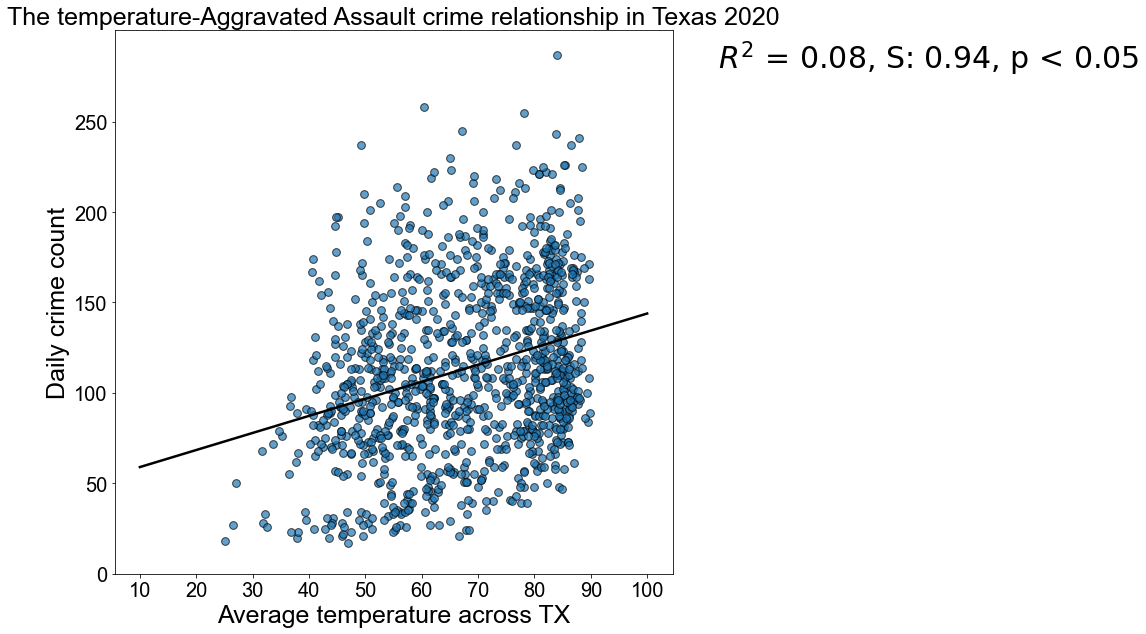

In [32]:
def plot_temperature_crime_relationship(type):
    df_Texas_by_date = (
    df_crime_data[(df_crime_data['UCR Offense Code']==type)
                  & (df_crime_data['State Code']==42)]
        .groupby('Incident Date')
        .size()
        )
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(df_weather_texas_by_date_2020["TAVG Fahrenheit"].tolist(), df_Texas_by_date.values.tolist(), s=60, alpha=0.7, edgecolors="k")

    slope, intercept, r, p, se = linregress(df_weather_texas_by_date_2020["TAVG Fahrenheit"].tolist(), df_Texas_by_date.values.tolist())
    crime_pred = slope * df_weather_texas_by_date_2020["TAVG Fahrenheit"] + intercept
    r2 = r2_score(df_Texas_by_date.values.tolist(), crime_pred)
    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(10, 100, num=100)
    # Plot regression line
    plt.plot(xseq, intercept + slope * xseq, color="k", lw=2.5)
    local_max = int(np.max(df_Texas_by_date.values.tolist()) / 50) * 50 + 50
    local_min = int(np.min(df_Texas_by_date.values.tolist()) / 50) * 50
    plt.xticks(np.arange(10, 101, step=10), fontname = "Arial", fontsize=20)
    plt.yticks(np.arange(local_min, local_max, step=50), fontname = "Arial", fontsize=20)
    plt.xlabel("Average temperature across TX", fontname = "Arial", fontsize=25)
    plt.ylabel("Daily crime count", fontname = "Arial", fontsize=25)
    p_str = ", p < 0.05" if p < 0.05 else ", p: " + str(round(p, 2))
    plt.text(150, local_max * 0.95,
                        '${R^2}$ = ' + str(round(r2, 2)) + ", S: " + str(round(slope, 2)) + p_str,
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=30)
    plt.title("The temperature-" + type + " crime relationship in Texas 2020", fontname = "Arial", fontsize=25)
    plt.show()
    return


plot_temperature_crime_relationship("Aggravated Assault")

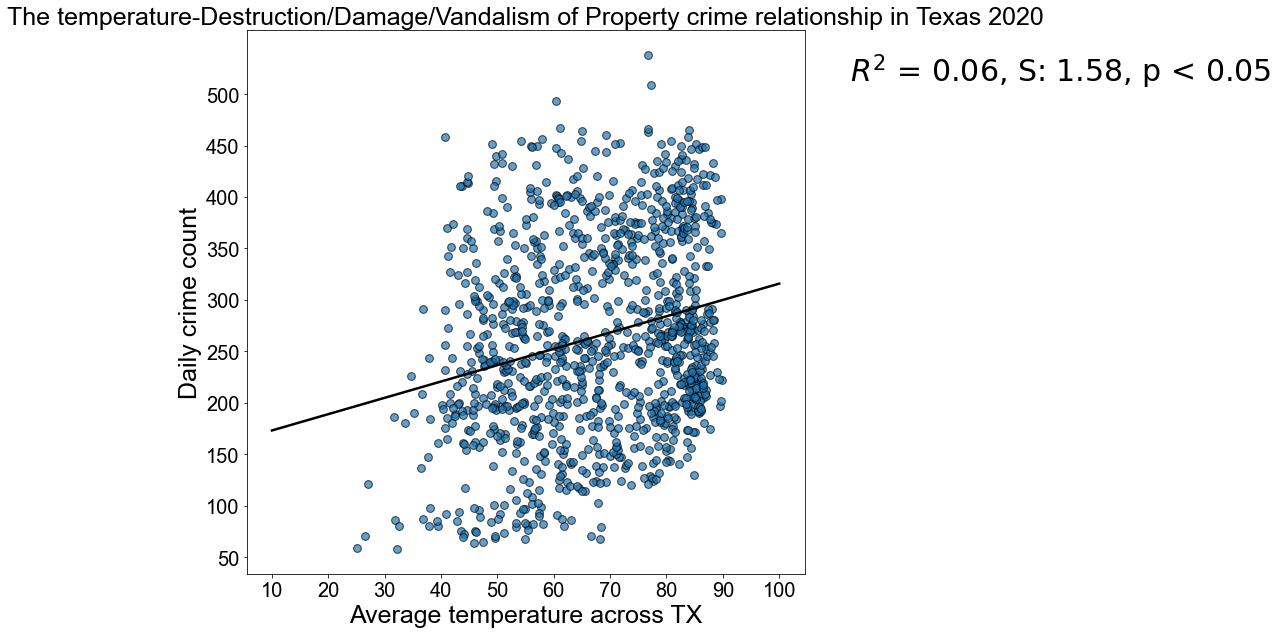

In [33]:
plot_temperature_crime_relationship("Destruction/Damage/Vandalism of Property")


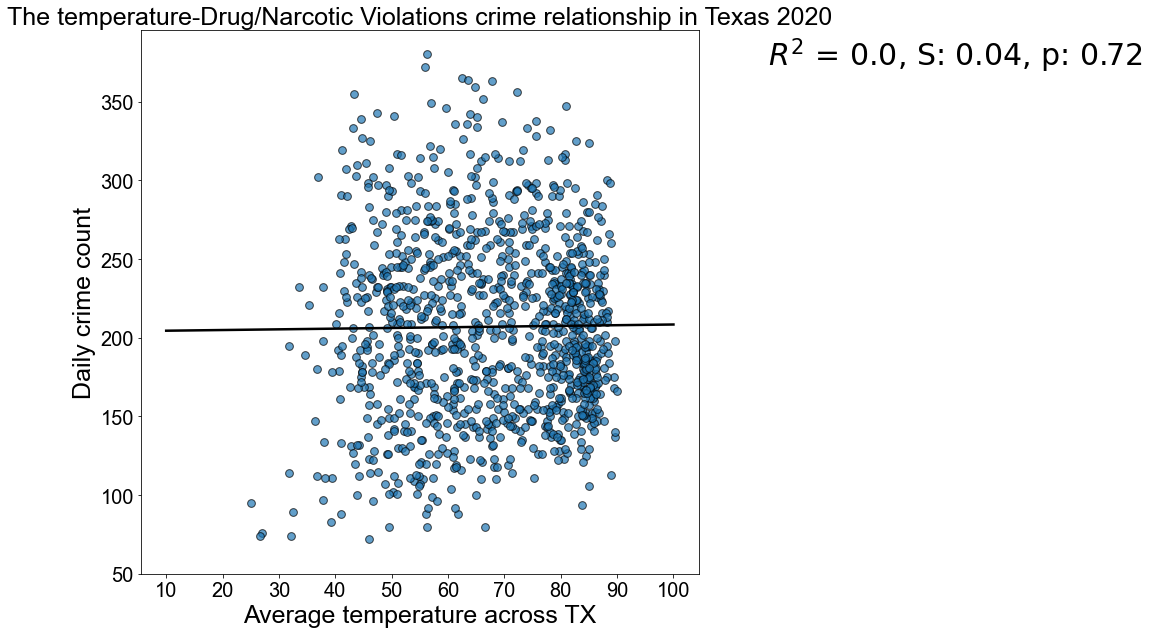

In [34]:
plot_temperature_crime_relationship("Drug/Narcotic Violations")


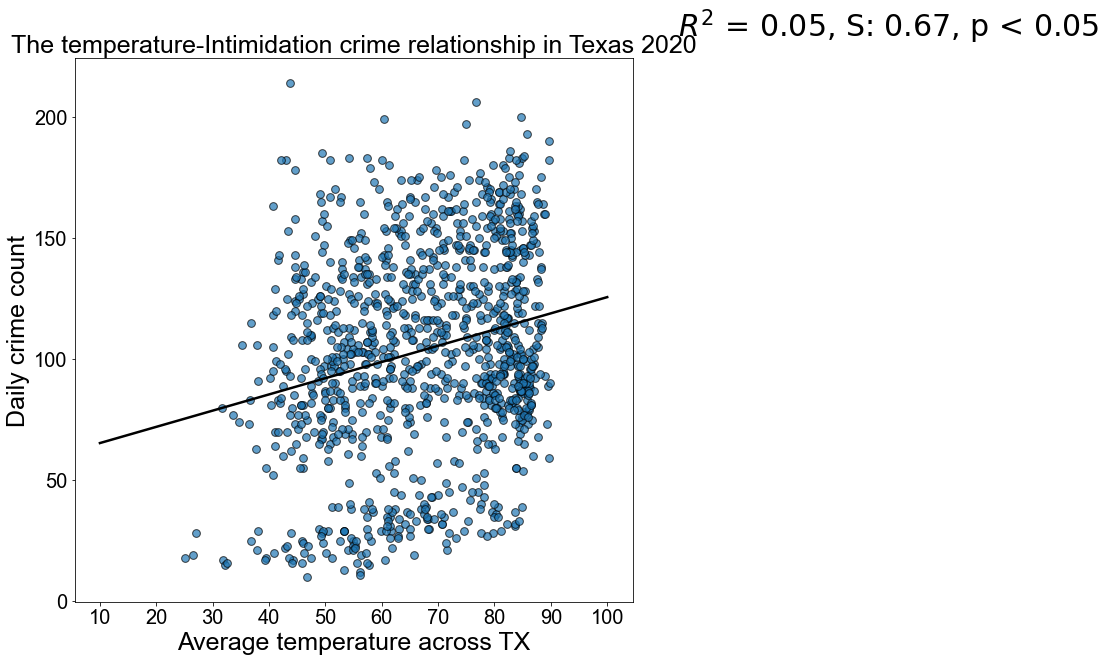

In [35]:
plot_temperature_crime_relationship("Intimidation")


#### Analysis: 
Interestingly, we can see some crimes have a stronger relationship between temperature and the daily crime count. For example, 'Intimidation' and 'Aggravated Assault' have a somewhat linear relationship with termpature, while 'Drug/Narcotics' does not. For the latter, the relationship appears to be constant.

### Relationship between Z-Score/Temperature Ratio and Number of Arrests

We can then try and use the Z-Score and Temperature ratio plotted against the Number of Arrests per day to determine if there is a relationship between the two variables. If so, we can use these as features to our model.

In [36]:
df_simple_assault_texas_by_date = (
    df_crime_data[(df_crime_data['State Code']==42)]
    .groupby('Incident Date')
    .size()

)                                 
df_simple_assault_texas_by_date

Incident Date
2018-01-01    1268
2018-01-02     897
2018-01-03     927
2018-01-04     974
2018-01-05    1110
              ... 
2020-12-27    3521
2020-12-28    4127
2020-12-29    3965
2020-12-30    3619
2020-12-31    3289
Length: 1096, dtype: int64

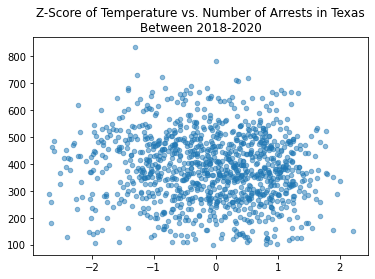

In [78]:
df_weather_texas_valid = (
    df_weather_texas[(df_weather_texas['Date'].astype(str) >= "2018-01-01")
    & (df_weather_texas['Date'].astype(str) <= "2020-12-32")]

)

crime_count = df_crime_data[['Incident Date', 'UCR Offense Code']].groupby('Incident Date').count().iloc[:, 0]

df_weather_texas_valid

plt.scatter(df_weather_texas_valid['Z-Score'], df_simple_assault_Texas_by_date, s=20, alpha=0.5)
plt.title('Z-Score of Temperature vs. Number of Arrests in Texas\n\
Between 2018-2020');

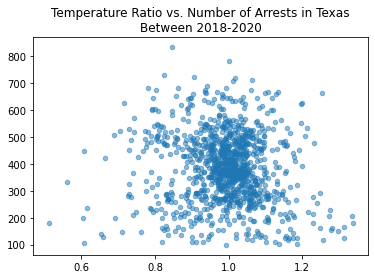

In [38]:
plt.scatter(df_weather_texas_valid['Temp Ratio'], df_simple_assault_Texas_by_date, s=20, alpha=0.5)
plt.title('Temperature Ratio vs. Number of Arrests in Texas\n\
Between 2018-2020');

We can do the same for a different state with potentially more temperature variablility, such as Michigan.

In [134]:
# get Michigan weather and graph average over 2010-2021 years
df_weather_michigan_raw = df_states_weather_years[df_states_weather_years['state']=='Michigan']
df_weather_michigan_average = (
    df_weather_michigan_raw
    .groupby('Day of Year')[['TAVG Fahrenheit']]
    .mean()
    .rename(columns={'TAVG Fahrenheit': 'Yearly TAVG Fahrenheit'})
)

# get standard deviation
df_weather_michigan_std = (
    df_weather_michigan_raw
    .groupby('Day of Year')[['TAVG Fahrenheit']]
    .std()
    .rename(columns={'TAVG Fahrenheit': 'Yearly STD Fahrenheit'})
)

In [136]:
# merge the average and std into dataframe
df_weather_michigan = (
    df_weather_michigan_raw
    .merge(right=df_weather_michigan_average, how='inner', on='Day of Year')
    .merge(right=df_weather_michigan_std, how='inner', on='Day of Year')
)

# calculate Z-Score
df_weather_michigan['Z-Score'] = \
    (df_weather_michigan['TAVG Fahrenheit']\
    - df_weather_michigan['Yearly TAVG Fahrenheit'])\
    / df_weather_michigan['Yearly STD Fahrenheit']

# calculate temp ratio
df_weather_michigan['Temp Ratio'] = \
    df_weather_michigan['TAVG Fahrenheit']\
    / df_weather_michigan['Yearly TAVG Fahrenheit']

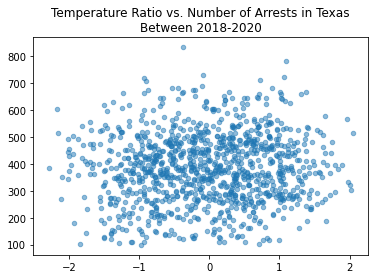

In [137]:
# get the valid dates
df_weather_michigan_valid = (
    df_weather_michigan[(df_weather_michigan['Date'].astype(str) >= "2018-01-01")
    & (df_weather_michigan['Date'].astype(str) <= "2020-12-32")]
)

# get the crime in michigan
df_crime_michigan_by_date = (
    df_crime_data[(df_crime_data['State Code']==42) & \
                 (df_crime_data['UCR Offense Code']=='Simple Assault')]
    .groupby('Incident Date')
    .size()
)                                 

# plot
plt.scatter(df_weather_michigan_valid['Z-Score'], df_crime_michigan_by_date, s=20, alpha=0.5)
plt.title('Temperature Ratio vs. Number of Arrests in Texas\n\
Between 2018-2020');

#### Analysis:
Interestingly, there is no linear relationship between the two variables Z-score and temperature ratio and Number of Arrests. This is further discussed in our 'Future Work' section in our paper. Therefore, it appears the absolute temperature is a better feature for our model, which we will use in a later part of this notebook.

### Plots of Absolute Temperature vs. Number of Arrests for United States

In [39]:
# df_weather_by_date = df_states_weather_years.groupby('Date').mean()
df_states_weather_years_valid = (
    df_states_weather_years[(df_states_weather_years['Date'].astype(str) >= "2018-01-01")
    & (df_states_weather_years['Date'].astype(str) <= "2020-12-32")]

)

df_combined = df_states_weather_years_valid.groupby('Date').mean()

crime_count = df_crime_data[['Incident Date', 'UCR Offense Code']].groupby('Incident Date').count().iloc[:, 0]
# df_crime_and_weather 
# df_combined = (
#     df_combined
#     .merge(right=crime_count, how='inner', left_on='Date', right_on='Incident Date')
# )

df_combined['Number of Arrests'] = crime_count

In [40]:
df_combined

,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests
Date,,,,,,,,
2018-01-01,-94.627799,2.458049,14.966996,39.741907,-94.113985,662.083023,1.0,22191
2018-01-02,-84.161101,4.886727,16.851002,39.743808,-94.107875,662.181211,2.0,15593
2018-01-03,-48.851433,7.294490,23.206742,39.741760,-94.109363,662.277135,3.0,15679
2018-01-04,-45.288121,40.193071,23.848138,39.741411,-94.109205,662.293622,4.0,14894
2018-01-05,-53.816997,7.798497,22.312941,39.738998,-94.107293,662.073245,5.0,15969
...,...,...,...,...,...,...,...,...
2020-12-27,4.797579,5.342429,32.863564,39.750167,-94.127212,683.302062,362.0,19832
2020-12-28,15.218654,10.191935,34.739358,39.741932,-94.139490,683.225707,363.0,23714
2020-12-29,2.298205,24.869546,32.413677,39.753299,-94.111898,681.361381,364.0,22442


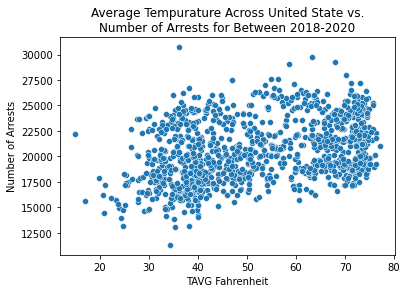

In [41]:
sns.scatterplot(data=df_combined, x='TAVG Fahrenheit', y='Number of Arrests')
plt.title('Average Tempurature Across United State vs.\n\
Number of Arrests for Between 2018-2020');

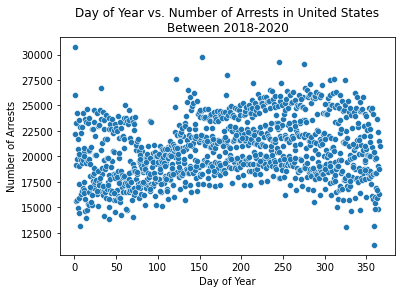

In [42]:
sns.scatterplot(data=df_combined, x='Day of Year', y='Number of Arrests')
plt.title('Day of Year vs. Number of Arrests in United States\n\
Between 2018-2020');

# Data Modeling and Inferences

Our machine learning problem is to investigate, given features related to weather and/or day of the year, if we can predict the number of crimes. That is, we will be investigating if features such as temperature, precipitation, day of the week, day of the year, and/or location can help predict the number of crimes on a given day.

We plan on using ordinary least squares for our model. As seen in Exploratory Data Analysis Section, there is relationship between the temperature and the number of crimes. After a baseline model, we can add features to improve our prediction accuracy.

### Ordinary Least Squares

In [43]:
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split

In [44]:
train, test = train_test_split(df_combined, test_size = 0.20, random_state = 42)

print('Training set size: {}'.format(train.size))
print('Test set size: {}'.format(test.size))

train

Training set size: 7008
Test set size: 1760


,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests
Date,,,,,,,,
2018-01-03,-48.851433,7.294490,23.206742,39.741760,-94.109363,662.277135,3.0,15679
2018-01-07,-40.469225,15.526930,24.715539,39.737105,-94.120531,663.017475,7.0,13126
2019-08-14,223.189584,26.460453,72.174125,39.739062,-93.750356,647.326730,226.0,21135
2019-09-27,176.154145,27.464008,63.707746,39.733528,-93.762722,649.560900,270.0,23253
2020-04-22,96.057489,36.082176,49.290348,39.754104,-93.765673,670.306210,113.0,20146
...,...,...,...,...,...,...,...,...
2018-11-27,14.538287,35.834807,34.616892,39.729995,-94.142488,662.379351,331.0,17128
2019-04-12,89.247961,37.356685,48.064633,39.739890,-94.132945,665.146135,102.0,21042
2018-05-02,165.641993,27.865728,61.815559,39.725973,-93.732069,648.094011,122.0,18346


In [45]:
# Copied from Project 1B
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [46]:
X_train = train['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)
X_test = test['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)
y_train = train['Number of Arrests'].to_numpy().reshape(-1, 1)
y_test = test['Number of Arrests'].to_numpy().reshape(-1, 1)

In [47]:
linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)

LinearRegression()

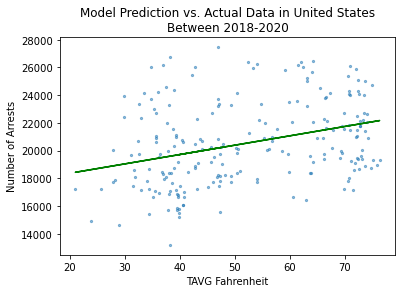

In [48]:
y_predicted = linear_model.predict(X_test)

plt.scatter(X_test, y_test, alpha = 0.5, s=5)
plt.plot(X_test, y_predicted, color='g')
plt.title('Model Prediction vs. Actual Data in United States\n\
Between 2018-2020')
plt.xlabel('TAVG Fahrenheit')
plt.ylabel('Number of Arrests');

Text(0.5, 0, 'Predicted Number of Crimes')

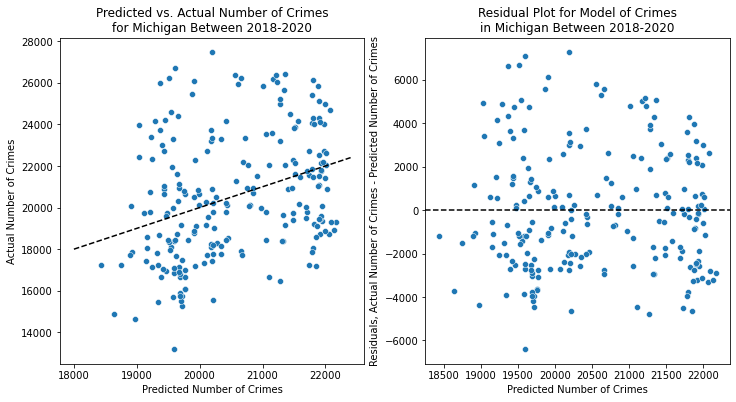

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
y_y_hat_line = np.arange(18000, 22500, 100)
sns.scatterplot(x=y_predicted[:, 0], y=y_test[:, 0])
plt.plot(y_y_hat_line, y_y_hat_line, color='black', linestyle=('--'))
plt.title('Predicted vs. Actual Number of Crimes\n\
for Michigan Between 2018-2020')
plt.ylabel('Actual Number of Crimes')
plt.xlabel('Predicted Number of Crimes')

plt.subplot(122)  
plt.axhline(0, color='black', linestyle=('--'))
sns.scatterplot(x=y_predicted[:, 0], y=y_test[:, 0] - y_predicted[:, 0])
plt.title('Residual Plot for Model of Crimes\n\
in Michigan Between 2018-2020')
plt.ylabel('Residuals, Actual Number of Crimes - Predicted Number of Crimes')
plt.xlabel('Predicted Number of Crimes')

In [50]:
print('RMSE: ', rmse(linear_model.predict(X_train), y_train))

RMSE:  2814.0333454066226


Because weather can change highly across the entire country, lets turn to a specific state. We look at Michigan, as the weather in a state in the midwest changes significantly from the summer (hot and humid) to the winter (cold and dry). 

In [79]:
crime_MI_by_date = (
    df_crime_data[(df_crime_data['State Code']==21)]
    .groupby('Incident Date')
    .size()

)                                 
crime_MI_by_date

Incident Date
2018-01-01    1572
2018-01-02    1179
2018-01-03    1261
2018-01-04    1192
2018-01-05    1144
              ... 
2020-12-27     851
2020-12-28    1088
2020-12-29     960
2020-12-30    1006
2020-12-31     924
Length: 1096, dtype: int64

In [80]:
# add the valid states to a dataframe
df_weather_MI = df_states_weather_years[df_states_weather_years['state']=='Michigan']
df_weather_MI_valid = (
    df_weather_MI[(df_weather_MI['Date'].astype(str) >= "2018-01-01")
    & (df_weather_MI['Date'].astype(str) <= "2020-12-32")]
).copy()
df_weather_MI_valid

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year
103582,2018-01-01,Michigan,-141.4,13.1,6.548,43.87703,-84.3486,227.03,1
103631,2018-01-02,Michigan,-105.3,2.8,13.046,43.87703,-84.3486,227.03,2
103680,2018-01-03,Michigan,-116.6,15.1,11.012,43.87703,-84.3486,227.03,3
103729,2018-01-04,Michigan,-147.2,1.8,5.504,43.87703,-84.3486,227.03,4
103778,2018-01-05,Michigan,-187.9,1.8,-1.822,43.87703,-84.3486,227.03,5
...,...,...,...,...,...,...,...,...,...
157845,2020-12-27,Michigan,-21.8,17.2,28.076,43.87703,-84.3486,227.03,362
157894,2020-12-28,Michigan,-2.8,15.3,31.496,43.87703,-84.3486,227.03,363
157943,2020-12-29,Michigan,-42.8,20.6,24.296,43.87703,-84.3486,227.03,364
157992,2020-12-30,Michigan,-7.2,77.1,30.704,43.87703,-84.3486,227.03,365


In [81]:
df_weather_MI_valid['Number of Arrests'] = crime_MI_by_date.tolist()
df_weather_MI_valid

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests
103582,2018-01-01,Michigan,-141.4,13.1,6.548,43.87703,-84.3486,227.03,1,1572
103631,2018-01-02,Michigan,-105.3,2.8,13.046,43.87703,-84.3486,227.03,2,1179
103680,2018-01-03,Michigan,-116.6,15.1,11.012,43.87703,-84.3486,227.03,3,1261
103729,2018-01-04,Michigan,-147.2,1.8,5.504,43.87703,-84.3486,227.03,4,1192
103778,2018-01-05,Michigan,-187.9,1.8,-1.822,43.87703,-84.3486,227.03,5,1144
...,...,...,...,...,...,...,...,...,...,...
157845,2020-12-27,Michigan,-21.8,17.2,28.076,43.87703,-84.3486,227.03,362,851
157894,2020-12-28,Michigan,-2.8,15.3,31.496,43.87703,-84.3486,227.03,363,1088
157943,2020-12-29,Michigan,-42.8,20.6,24.296,43.87703,-84.3486,227.03,364,960
157992,2020-12-30,Michigan,-7.2,77.1,30.704,43.87703,-84.3486,227.03,365,1006


Plotting the data, we see that there is a clear relationship between increase temperature and number of crimes. We fit this data to a linear model.

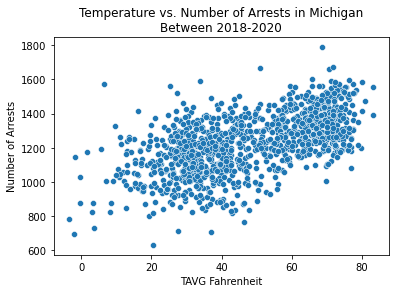

In [82]:
sns.scatterplot(data=df_weather_MI_valid, x='TAVG Fahrenheit', y='Number of Arrests')
plt.title('Temperature vs. Number of Arrests in Michigan\n\
Between 2018-2020');

In [83]:
train_MI, test_MI = train_test_split(df_weather_MI_valid, test_size = 0.25, random_state = 42)
train_MI

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests
106550,2018-03-02,Michigan,-0.8,0.3,31.856,43.87703,-84.3486,227.03,61,1277
125980,2019-03-28,Michigan,86.3,1.1,47.534,43.87703,-84.3486,227.03,87,1152
108121,2018-04-03,Michigan,11.4,125.7,34.052,43.87703,-84.3486,227.03,93,1312
138552,2019-12-06,Michigan,4.1,9.2,32.738,43.87703,-84.3486,227.03,340,1339
139752,2019-12-30,Michigan,40.4,258.1,39.272,43.87703,-84.3486,227.03,364,1158
...,...,...,...,...,...,...,...,...,...,...
119992,2018-11-27,Michigan,-23.6,1.7,27.752,43.87703,-84.3486,227.03,331,1163
126718,2019-04-12,Michigan,69.8,102.8,44.564,43.87703,-84.3486,227.03,102,1227
109571,2018-05-02,Michigan,190.6,77.0,66.308,43.87703,-84.3486,227.03,122,1478
155542,2020-11-10,Michigan,182.0,122.4,64.760,43.87703,-84.3486,227.03,315,1221


In [84]:
X_train_MI = train_MI['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)
X_test_MI = test_MI['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)
y_train_MI = train_MI['Number of Arrests'].to_numpy().reshape(-1, 1)
y_test_MI = test_MI['Number of Arrests'].to_numpy().reshape(-1, 1)

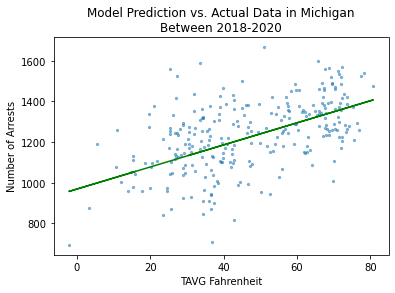

In [85]:
linear_model_MI = lm.LinearRegression(fit_intercept=True)
linear_model_MI.fit(X_train_MI, y_train_MI)

y_predicted_MI = linear_model_MI.predict(X_test_MI)

plt.scatter(X_test_MI, y_test_MI, alpha = 0.5, s=5)
plt.plot(X_test_MI, y_predicted_MI, color='g')
plt.title('Model Prediction vs. Actual Data in Michigan\n\
Between 2018-2020')
plt.xlabel('TAVG Fahrenheit')
plt.ylabel('Number of Arrests');

In [86]:
print('RMSE (Training Data): ',rmse(linear_model_MI.predict(X_train_MI), y_train_MI))
print('RMSE (Test Data): ',rmse(y_predicted_MI, y_test_MI))

RMSE (Training Data):  139.12880188879447
RMSE (Test Data):  147.09345550750388


In [87]:
df_weather_MI_valid

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests
103582,2018-01-01,Michigan,-141.4,13.1,6.548,43.87703,-84.3486,227.03,1,1572
103631,2018-01-02,Michigan,-105.3,2.8,13.046,43.87703,-84.3486,227.03,2,1179
103680,2018-01-03,Michigan,-116.6,15.1,11.012,43.87703,-84.3486,227.03,3,1261
103729,2018-01-04,Michigan,-147.2,1.8,5.504,43.87703,-84.3486,227.03,4,1192
103778,2018-01-05,Michigan,-187.9,1.8,-1.822,43.87703,-84.3486,227.03,5,1144
...,...,...,...,...,...,...,...,...,...,...
157845,2020-12-27,Michigan,-21.8,17.2,28.076,43.87703,-84.3486,227.03,362,851
157894,2020-12-28,Michigan,-2.8,15.3,31.496,43.87703,-84.3486,227.03,363,1088
157943,2020-12-29,Michigan,-42.8,20.6,24.296,43.87703,-84.3486,227.03,364,960
157992,2020-12-30,Michigan,-7.2,77.1,30.704,43.87703,-84.3486,227.03,365,1006


To try and decrease our RMSE (and therefore improve our model), lets attempt to use other features. We plot the Day of the Year and the number of arrests.

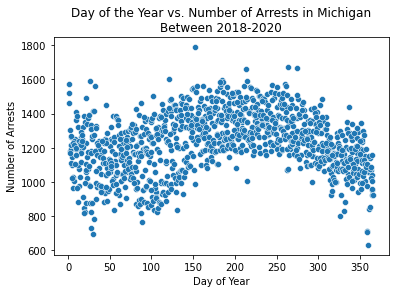

In [88]:
sns.scatterplot(data=df_weather_MI_valid, x='Day of Year', y='Number of Arrests')
plt.title('Day of the Year vs. Number of Arrests in Michigan\n\
Between 2018-2020');

There appears to be some sort of relationship between the day of the year and the number of arrests on that day (however, that relationship is non-linear). Day of the Year is also categorical, so we can attempt to one-hot encode the Day of the Year and use those as features to our linear model.

In [89]:
from sklearn.preprocessing import OneHotEncoder

def ohe_day(data):
    """
    One-hot-encodes the day of the year.  New columns are of the form x0_day.
    """
    ...
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Day of Year']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Day of Year']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

df_weather_MI_valid_day = ohe_day(df_weather_MI_valid)
df_weather_MI_valid_day

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests,...,Day of Year_357,Day of Year_358,Day of Year_359,Day of Year_360,Day of Year_361,Day of Year_362,Day of Year_363,Day of Year_364,Day of Year_365,Day of Year_366
103582,2018-01-01,Michigan,-141.4,13.1,6.548,43.87703,-84.3486,227.03,1,1572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103631,2018-01-02,Michigan,-105.3,2.8,13.046,43.87703,-84.3486,227.03,2,1179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103680,2018-01-03,Michigan,-116.6,15.1,11.012,43.87703,-84.3486,227.03,3,1261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103729,2018-01-04,Michigan,-147.2,1.8,5.504,43.87703,-84.3486,227.03,4,1192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103778,2018-01-05,Michigan,-187.9,1.8,-1.822,43.87703,-84.3486,227.03,5,1144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157845,2020-12-27,Michigan,-21.8,17.2,28.076,43.87703,-84.3486,227.03,362,851,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
157894,2020-12-28,Michigan,-2.8,15.3,31.496,43.87703,-84.3486,227.03,363,1088,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
157943,2020-12-29,Michigan,-42.8,20.6,24.296,43.87703,-84.3486,227.03,364,960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
157992,2020-12-30,Michigan,-7.2,77.1,30.704,43.87703,-84.3486,227.03,365,1006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Then, we can create a new model.

In [90]:
train_MI, test_MI = train_test_split(df_weather_MI_valid_day, test_size = 0.25, random_state = 42)

X_train_MI = train_MI.loc[:, 'Day of Year_1':'Day of Year_366'].to_numpy()
X_train_MI = np.hstack((X_train_MI, train_MI['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)))

X_test_MI = test_MI.loc[:, 'Day of Year_1':'Day of Year_366'].to_numpy()
X_test_MI = np.hstack((X_test_MI, test_MI['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)))

y_train_MI = train_MI['Number of Arrests'].to_numpy().reshape(-1, 1)
y_test_MI = test_MI['Number of Arrests'].to_numpy().reshape(-1, 1)

linear_model_MI = lm.LinearRegression(fit_intercept=True)
linear_model_MI.fit(X_train_MI, y_train_MI)

print('RMSE (Training Data): ', rmse(linear_model_MI.predict(X_train_MI), y_train_MI))
print('RMSE (Test Data): ', rmse(y_predicted_MI, y_test_MI))

print('Coefficients (first 10): ', linear_model_MI.coef_[0][0:10])

RMSE (Training Data):  114.93580169668175
RMSE (Test Data):  147.09345550750388
Coefficients (first 10):  [466.75839181 124.7922182   98.47674927  17.37680813  21.60733309
  -0.9593569   83.13661897  78.68827655 127.37909347 136.84312443]


However, adding day of the year as one-hot encoded features overfits our test data. We notice that the coefficients of the model are very large. Therefore, we can instead train a ridge-regression model that penalizes such highly weighted coefficients.

In [91]:
train_MI, test_MI = train_test_split(df_weather_MI_valid_day, test_size = 0.25, random_state = 42)

X_train_MI = train_MI.loc[:, 'Day of Year_1':'Day of Year_366'].to_numpy()
X_train_MI = np.hstack((X_train_MI, train_MI['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)))

X_test_MI = test_MI.loc[:, 'Day of Year_1':'Day of Year_366'].to_numpy()
X_test_MI = np.hstack((X_test_MI, test_MI['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)))

y_train_MI = train_MI['Number of Arrests'].to_numpy().reshape(-1, 1)
y_test_MI = test_MI['Number of Arrests'].to_numpy().reshape(-1, 1)

ridge_MI = lm.Ridge(fit_intercept=True, alpha=5)
ridge_MI.fit(X_train_MI, y_train_MI)

y_predicted_MI = ridge_MI.predict(X_test_MI)

print('RMSE (Training Data): ', rmse(ridge_MI.predict(X_train_MI), y_train_MI))
print('RMSE (Test Data): ', rmse(y_predicted_MI, y_test_MI))

print('Coefficients (first 10): ', ridge_MI.coef_[0][0:10])

RMSE (Training Data):  127.96184205976598
RMSE (Test Data):  152.17429997678693
Coefficients (first 10):  [129.70746331  31.94913196  15.7435669    3.49856684   3.76689713
  -4.4597993   12.70321323  21.79348111  44.26966089  48.67509877]


This does not appear to decrease our test set RMSE. However, since we are using the day of the year as a feature to the model, each day of the year only has 3 data points (2018, 2019, and 2020). Therefore, the data is _too_ specific, which may lead to overfitting. Instead, we can add a feature which is day of the month to generalize this feature.

In [92]:
# return to non-one hot encoded dataframe
df_weather_MI_valid

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests
103582,2018-01-01,Michigan,-141.4,13.1,6.548,43.87703,-84.3486,227.03,1,1572
103631,2018-01-02,Michigan,-105.3,2.8,13.046,43.87703,-84.3486,227.03,2,1179
103680,2018-01-03,Michigan,-116.6,15.1,11.012,43.87703,-84.3486,227.03,3,1261
103729,2018-01-04,Michigan,-147.2,1.8,5.504,43.87703,-84.3486,227.03,4,1192
103778,2018-01-05,Michigan,-187.9,1.8,-1.822,43.87703,-84.3486,227.03,5,1144
...,...,...,...,...,...,...,...,...,...,...
157845,2020-12-27,Michigan,-21.8,17.2,28.076,43.87703,-84.3486,227.03,362,851
157894,2020-12-28,Michigan,-2.8,15.3,31.496,43.87703,-84.3486,227.03,363,1088
157943,2020-12-29,Michigan,-42.8,20.6,24.296,43.87703,-84.3486,227.03,364,960
157992,2020-12-30,Michigan,-7.2,77.1,30.704,43.87703,-84.3486,227.03,365,1006


In [93]:
def ohe_month(data):
    """
    One-hot-encodes the day of the year.  New columns are of the form x0_month.
    """
    data['month'] = data['Date'].dt.month
    
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['month']])
    dummies = pd.DataFrame(oh_enc.transform(data[['month']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

df_weather_MI_valid_month = ohe_month(df_weather_MI_valid)
df_weather_MI_valid_month

,Date,state,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Number of Arrests,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
103582,2018-01-01,Michigan,-141.4,13.1,6.548,43.87703,-84.3486,227.03,1,1572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103631,2018-01-02,Michigan,-105.3,2.8,13.046,43.87703,-84.3486,227.03,2,1179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103680,2018-01-03,Michigan,-116.6,15.1,11.012,43.87703,-84.3486,227.03,3,1261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103729,2018-01-04,Michigan,-147.2,1.8,5.504,43.87703,-84.3486,227.03,4,1192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103778,2018-01-05,Michigan,-187.9,1.8,-1.822,43.87703,-84.3486,227.03,5,1144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157845,2020-12-27,Michigan,-21.8,17.2,28.076,43.87703,-84.3486,227.03,362,851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
157894,2020-12-28,Michigan,-2.8,15.3,31.496,43.87703,-84.3486,227.03,363,1088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
157943,2020-12-29,Michigan,-42.8,20.6,24.296,43.87703,-84.3486,227.03,364,960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
157992,2020-12-30,Michigan,-7.2,77.1,30.704,43.87703,-84.3486,227.03,365,1006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


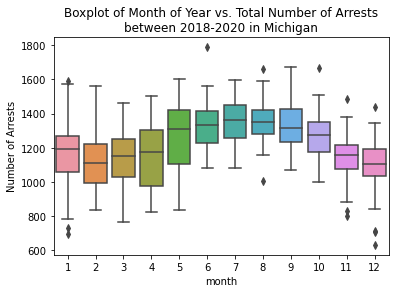

In [94]:
sns.boxplot(data=df_weather_MI_valid_month, x='month', y='Number of Arrests')
plt.title('Boxplot of Month of Year vs. Total Number of Arrests\n\
between 2018-2020 in Michigan');

In [95]:
train_MI_month, test_MI_month = train_test_split(df_weather_MI_valid_month, test_size = 0.25, random_state = 42)

X_train_MI_month = train_MI_month.loc[:, 'month_1':'month_12'].to_numpy()
X_train_MI_month = np.hstack((X_train_MI_month, train_MI_month['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)))

X_test_MI_month = test_MI_month.loc[:, 'month_1':'month_12'].to_numpy()
X_test_MI_month = np.hstack((X_test_MI_month, test_MI_month['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)))

y_train_MI_month = train_MI_month['Number of Arrests'].to_numpy().reshape(-1, 1)
y_test_MI_month = test_MI_month['Number of Arrests'].to_numpy().reshape(-1, 1)

linear_model_MI_month = lm.LinearRegression(fit_intercept=True)
linear_model_MI_month.fit(X_train_MI_month, y_train_MI_month)

y_predicted_MI_month = linear_model_MI_month.predict(X_test_MI_month)

print('RMSE (Training Data):', rmse(linear_model_MI_month.predict(X_train_MI_month), y_train_MI_month))
print('RMSE (Test Data):', rmse(y_predicted_MI_month, y_test_MI_month))

RMSE (Training Data): 136.18787394280716
RMSE (Test Data): 144.1420909177525


As we can see, the test data RMSE is decreased slightly (from 147 vs. 144), but not significantly. This is likely because temperature data is correlated with the month of the year--that is, the temperature data already 'includes' the month of the year. Hotter temperatures typically will occur during the summer, and colder temperatures will typically occur in the winter. In other words, it is likely that the temperature and month of the year are **collinear** features.

# Models for Violent vs. Non-violent Crime
We can then turn to building models for violent or non-violent crimes, to see if there are any relationships between those features.

Since these will contain similar transformation and features, we can define a function to first filter the data we are interested in. Specifically, we want to filter such that we have the daily arrest rate that we are interested in, as well as the state we are interested in.

,TAVG,PRCP,TAVG Fahrenheit,Latitude,Longitude,Elevation,Day of Year,Daily Crime Count
Date,,,,,,,,
2018-01-01,-94.627799,2.458049,14.966996,39.741907,-94.113985,662.083023,1.0,840
2018-01-02,-84.161101,4.886727,16.851002,39.743808,-94.107875,662.181211,2.0,418
2018-01-03,-48.851433,7.294490,23.206742,39.741760,-94.109363,662.277135,3.0,438
2018-01-04,-45.288121,40.193071,23.848138,39.741411,-94.109205,662.293622,4.0,449
2018-01-05,-53.816997,7.798497,22.312941,39.738998,-94.107293,662.073245,5.0,478
...,...,...,...,...,...,...,...,...
2020-12-27,4.797579,5.342429,32.863564,39.750167,-94.127212,683.302062,362.0,1086
2020-12-28,15.218654,10.191935,34.739358,39.741932,-94.139490,683.225707,363.0,914
2020-12-29,2.298205,24.869546,32.413677,39.753299,-94.111898,681.361381,364.0,894


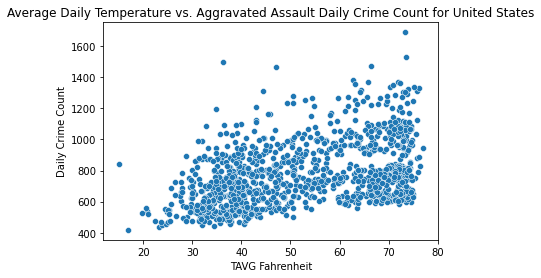

In [104]:
def get_combined_df_specific_crime(weather_data_raw,
                                   crime_data_raw,
                                   crime,
                                   location,
                                   state_code=None,
                                   ):
    '''
    Gets the Valid weather data and Crime data for a specific state code,
    adds the daily crime count for that crime into the weather data, and
    returns the dataframe
    '''
    # get the crime data for specific 'crimes' in specific 'state_code'
    curr_df_crime = crime_data_raw[crime_data_raw['UCR Offense Code'].isin([crime])]
    
    if state_code is not None:
         curr_df_crime = curr_df_crime[curr_df_crime['State Code'].isin([state_code])]
    
    # get the corresponding weather data between 2018-2020
    curr_df_weather_valid = (
        weather_data_raw[(weather_data_raw['Date'].astype(str) >= "2018-01-01")
        & (weather_data_raw['Date'].astype(str) <= "2020-12-32")]
    )
    
    # group the weather data by day, taking the average
    df = curr_df_weather_valid.groupby('Date').mean()
    
    # add the daily crime count to the dataframe
    curr_crime_count = curr_df_crime[['Incident Date', 'UCR Offense Code']].groupby('Incident Date').count().iloc[:, 0]
    df['Daily Crime Count'] = curr_crime_count
    
    # plot the data between the Date and the crime
    sns.scatterplot(data=df, x='TAVG Fahrenheit', y='Daily Crime Count')
    plt.title('Average Daily Temperature vs. {} Daily Crime Count for {}'.format(crime, location))
    
    return df

crime='Aggravated Assault'
location_str='United States'
state_code = None
df_agg_assault = get_combined_df_specific_crime(df_states_weather_years,
                                                   df_crime_data,
                                                   crime,
                                                   location_str)

df_agg_assault

Then, we can create a function to fit a linear model.

RMSE (Training Data):  181.5094382191632
RMSE (Test Data):  186.16914208198466


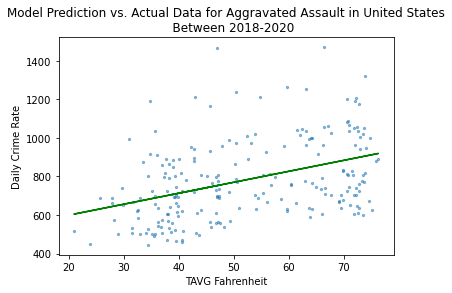

In [105]:
def linear_model_crime(data, crime, location):
    train, test = train_test_split(data, test_size = 0.20, random_state = 42)

    X_train = train['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)
    X_test = test['TAVG Fahrenheit'].to_numpy().reshape(-1, 1)
    y_train = train['Daily Crime Count'].to_numpy().reshape(-1, 1)
    y_test = test['Daily Crime Count'].to_numpy().reshape(-1, 1)

    linear_model = lm.LinearRegression(fit_intercept=True)
    linear_model.fit(X_train, y_train)

    y_predicted = linear_model.predict(X_test)

    plt.scatter(X_test, y_test, alpha = 0.5, s=5)
    plt.plot(X_test, y_predicted, color='g')
    plt.title('Model Prediction vs. Actual Data for {} in {}\n\
    Between 2018-2020'.format(crime, location))
    plt.xlabel('TAVG Fahrenheit')
    plt.ylabel('Daily Crime Rate');
    
    print('RMSE (Training Data): ',rmse(linear_model.predict(X_train), y_train))
    print('RMSE (Test Data): ',rmse(y_predicted, y_test))
    
linear_model_crime(df_agg_assault, crime, location_str)

We can look specifically at Michigan's aggravated assault.

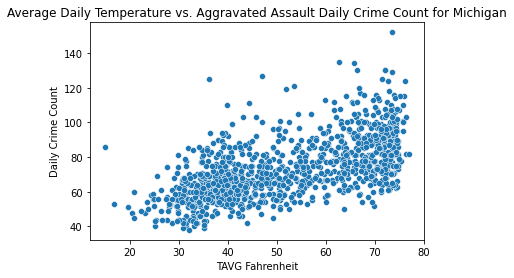

In [106]:
crime='Aggravated Assault'
location_str='Michigan'
state_code = 21 # michigan has state code 21
df_agg_assault_MI = get_combined_df_specific_crime(df_states_weather_years,
                                                   df_crime_data,
                                                   crime,
                                                   location_str,
                                                   state_code=21)

RMSE (Training Data):  13.811680778792898
RMSE (Test Data):  13.740965094776772


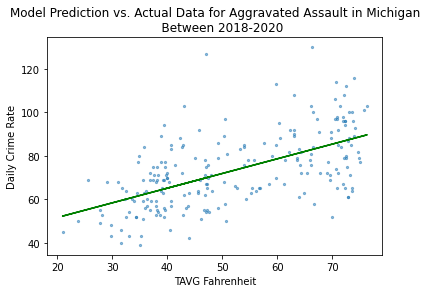

In [107]:
linear_model_crime(df_agg_assault_MI, crime, location_str)

We can directly compare this to a crime where we do not see such a prominent linearly relationship, such as drugs/narcotics.

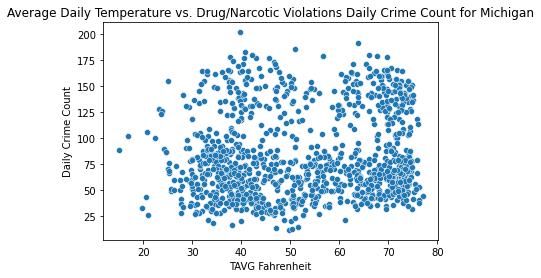

In [109]:
crime='Drug/Narcotic Violations'
location_str='Michigan'
state_code = 21 # michigan has state code 21
df_drugs_MI = get_combined_df_specific_crime(df_states_weather_years,
                                                   df_crime_data,
                                                   crime,
                                                   location_str,
                                                   state_code=21)

RMSE (Training Data):  39.64169639611745
RMSE (Test Data):  42.28549816473667


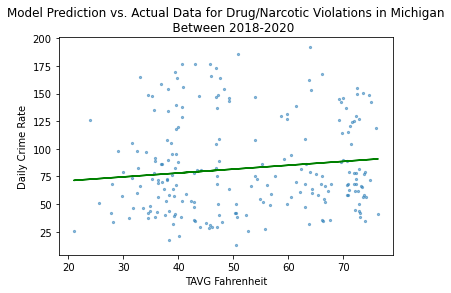

In [111]:
linear_model_crime(df_drugs_MI, crime, location_str)

In essense, this is a constant model. That is, for any given temperature (for a given day of the year), Michigan can expect roughly 75 arrests a day related to Drug/Narcotic Violations. This is unlike Aggravated Assult arrests. If the temperature is roughly 30 degrees Fahrenheit, there will be roughly 55 arrests across the state. However, if the temperature is roughly 70 degree Fahrenheit, there may be potentially 80 arrests across the state.

We can see this near-constant relationship for Drugs/Narcotic Violations hold true for across the United States.

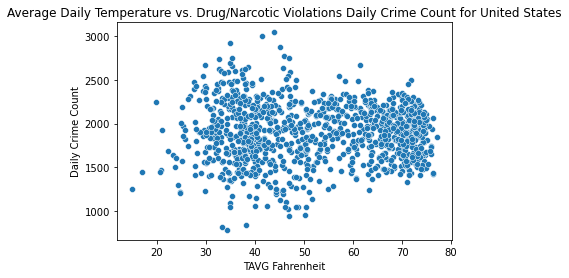

In [112]:
crime='Drug/Narcotic Violations'
location_str='United States'
df_drugs_US = get_combined_df_specific_crime(df_states_weather_years,
                                                   df_crime_data,
                                                   crime,
                                                   location_str)

RMSE (Training Data):  326.77305021720406
RMSE (Test Data):  328.598140264571


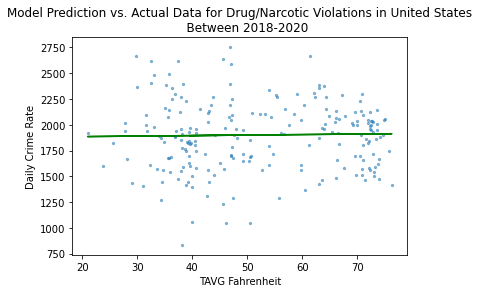

In [114]:
linear_model_crime(df_drugs_US, crime, location_str)